In [2]:
from __future__ import print_function
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from numpy import save
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

import time


In [3]:
import sys

sys.path.append("C:/Users/admin/Desktop/IP Paris/MICAS/Cours/910/913 - Deep Learning/Project/")

# Import helper functions
from networks import NeuralNetwork
from optimization.optimizers import StochasticGradientDescent, Adam, RMSprop, Adagrad, Adadelta
from networks.loss_functions import CrossEntropy, SquareLoss
from utils.misc import bar_widgets
from networks.layers import Dense, Dropout, Activation, BatchNormalization

from helpers.helper import *
from helpers.processing import *

from Channel.parameters import *
from Channel.transmitor import *
from Channel.modulator import *
from Channel.channel import *
from Channel.equalizer import *
from Channel.demodulator import *
from Channel.detector import *
from nnet_Generator.NNetGenerator import *

Using TensorFlow backend.


In [4]:
# For styling the figures.

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

plt.rcParams["figure.figsize"] = (15,7)

# 2.2 Channel model
### Signal and system parameters

* parameters are defined in the Parameters class

In [158]:
# bandwidth
bandwidth = 1
# Number of symbols
nsymbols = 1
# Size of the constellation
M = 16
# Sample size
Nt = 2**10
# Number of Layers of the Generative network
nLayers = 500
# Number of bits
nb = int(nsymbols * np.log2(M))
# Time mesh
timeMesh = int( (nb/bandwidth)+ (10*2/ nb) )

In [159]:
# Initialize parameters
parameters = Parameters(bandwidth, nsymbols, M, Nt, nLayers, timeMesh)
#params = Parameters(bandwidth, nsymbols, M, Nt, nLayers, timeMesh)
# Initialize the Transmitor
transmitor = Transmitor()
# Initialize the Modulator
modulator = Modulator()
# Initialize the Channel
channel = Channel()
# Initialize the Equalizer
equalizer = Equalizer()
# Initialize the NNetGenerator
nnetGen = NNetGenerator(parameters)
# Initialize the Detector
detector = Detector(transmitor)
# Initialize the Demodulator
demodulator = Demodulator()

### Question 4 : Consider the peak power P=6 mW. Obtain the normalize peak power and plot the constellation C

In [160]:
parameters.power

0.06

In [161]:
parameters.M

16

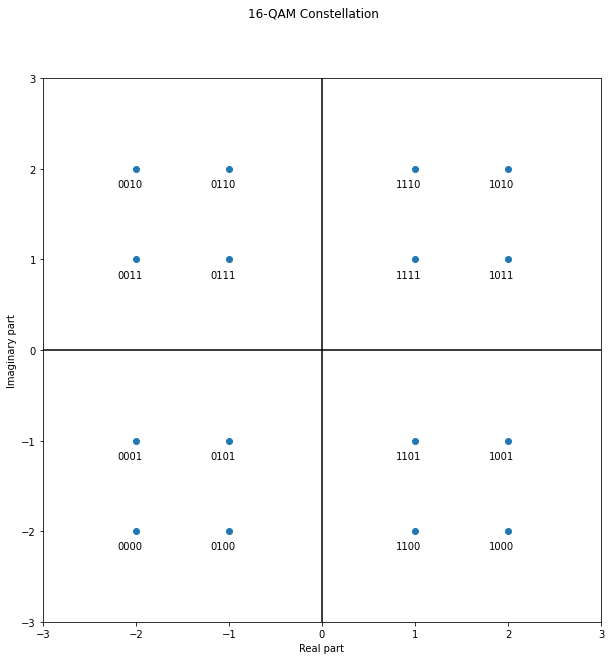

In [162]:
# Constellation
constellation, binary_str, binary_arr = transmitor.build_constellations(parameters.M)
transmitor.plot_constellation(parameters.M, constellation, binary_str)

In [163]:
print(constellation)
print(binary_str)
print(binary_arr)

[-2.-2.j -2.-1.j -2.+2.j -2.+1.j -1.-2.j -1.-1.j -1.+2.j -1.+1.j  2.-2.j
  2.-1.j  2.+2.j  2.+1.j  1.-2.j  1.-1.j  1.+2.j  1.+1.j]
['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
[[0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 1 0]
 [0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]
 [1 0 1 1]
 [1 1 0 0]
 [1 1 0 1]
 [1 1 1 0]
 [1 1 1 1]]


## 2.2.1 Transmitter

### Question 5. Binary source

In [164]:
print("Probability of 0 : ", parameters.p)
print("Sample size : ", parameters.N)
print("Number of bits : ", parameters.nb)

Probability of 0 :  0.5
Sample size :  1024
Number of bits :  4


In [165]:
#source
b = transmitor.source(parameters.nb , parameters.p)
print("Generated source : \n", b)
print("len(source) : \n", len(b))

Generated source : 
 [1 1 1 0]
len(source) : 
 4


## Modulation
### Question 6. Bits-to-symbols mapping

In [166]:
# symbol sequence
s = transmitor.bit_to_symb(b, parameters.M)
print("symbols : \n", s)
print("len(symbols) : ", len(s))

symbols : 
 [1.+2.j]
len(symbols) :  1


The number of symbols matches the equation : $$ N/\log_{2}(M) = 4/\log_{2}(16) = 256 $$
Where N is the number of bits

### Question 7. Modulation function

In [167]:
q0t = modulator.mod(parameters.t, s, parameters.B)

### Plots in time domain

Text(0.5, 1.0, 'Modulated signal using sinc functions. Number of bits 4')

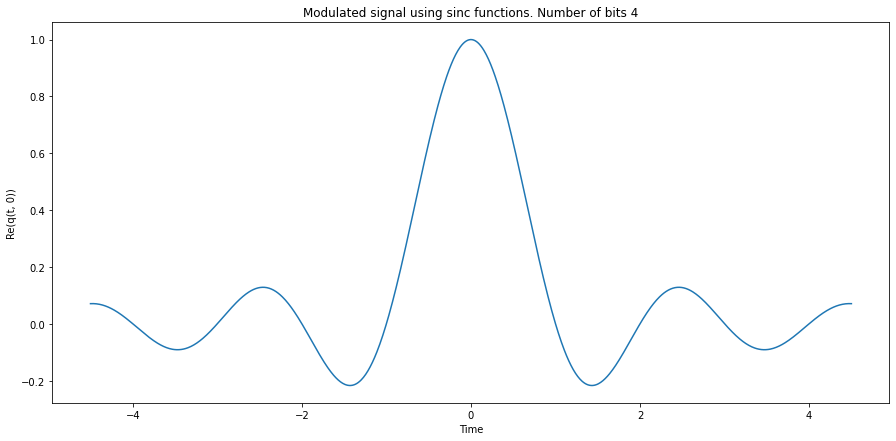

In [168]:
plt.plot(parameters.t, np.squeeze(q0t.real))
plt.xlabel('Time')
plt.ylabel('Re(q(t, 0))')
plt.title("Modulated signal using sinc functions. Number of bits "+str(parameters.nb))

Text(0.5, 1.0, 'Modulated signal using sinc functions. Number of bits 4')

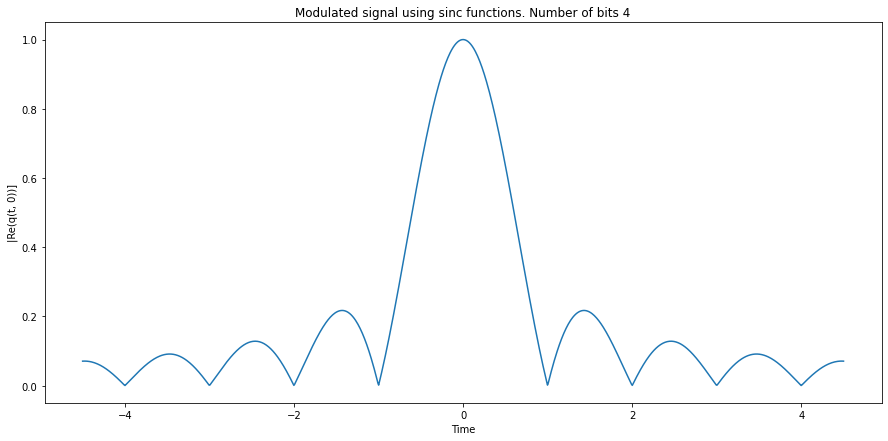

In [169]:
plt.plot(parameters.t, np.abs(np.squeeze(q0t.real)))
plt.xlabel('Time')
plt.ylabel('|Re(q(t, 0))]')
plt.title("Modulated signal using sinc functions. Number of bits "+str(parameters.nb))

### Plots in Frequency domain

In [170]:
q0f = np.fft.fft(q0t)
f = np.fft.fftfreq(parameters.N, parameters.dt)

Text(0.5, 1.0, 'Modulated signal using sinc functions. Number of bits 4')

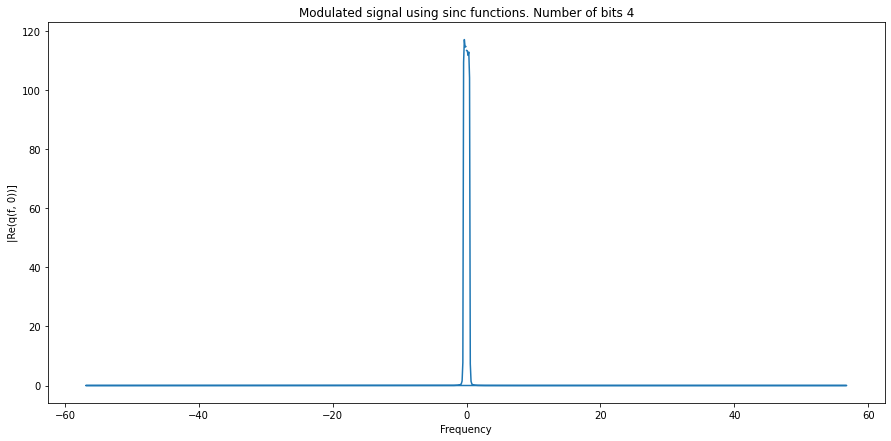

In [171]:
plt.plot(f, np.abs(np.squeeze(q0f.real)))
plt.xlabel('Frequency')
plt.ylabel('|Re(q(f, 0))]')
plt.title("Modulated signal using sinc functions. Number of bits "+str(parameters.nb))

## 2.2.2 Channel model

### Question 12. channel(t, q0t, z, sigma2, B) that outputs a realization of the stochastic process q(t,z) given q(t,0).

In [172]:
qzt, qzf = channel.channel(parameters.t, q0t, parameters.z, parameters.sigma2, parameters.B)

Text(0.5, 1.0, 'Modulated signal using sinc functions. Number of bits 4')

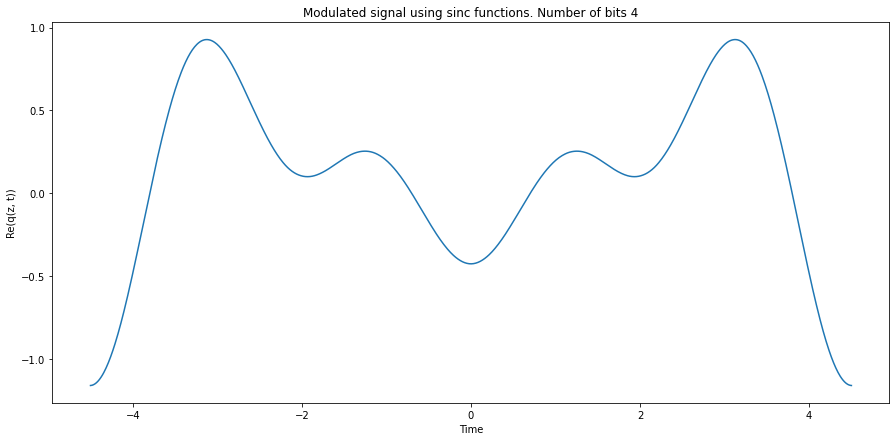

In [173]:
plt.plot(parameters.t, np.squeeze(qzt.real))
plt.xlabel('Time')
plt.ylabel('Re(q(z, t))')
plt.title("Modulated signal using sinc functions. Number of bits "+str(parameters.nb))

Text(0.5, 1.0, 'Modulated signal using sinc functions. Number of bits 4')

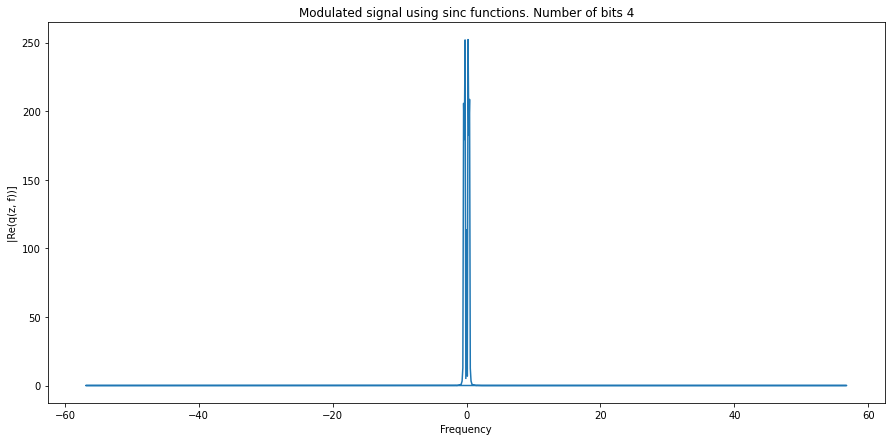

In [174]:
plt.plot(f, np.abs(np.squeeze(qzf.real)))
plt.xlabel('Frequency')
plt.ylabel('|Re(q(z, f))]')
plt.title("Modulated signal using sinc functions. Number of bits "+str(parameters.nb))

# 2.2.3 Receiver

## Equalization


**Main**
* We test the equalization part with a Gaussian input signal.


In [175]:
parameters.A

1

In [184]:
q0t = parameters.A*np.exp(-parameters.t**2)
q0f = np.fft.fft(q0t)

Text(0.5, 1.0, 'Gaussian input signal')

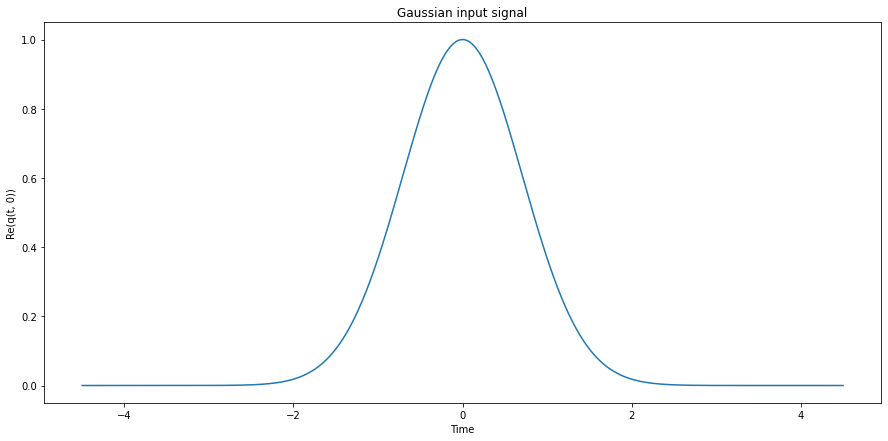

In [185]:
plt.plot(parameters.t, q0t.real)
plt.xlabel('Time')
plt.ylabel('Re(q(t, 0))')
plt.title("Gaussian input signal")

Text(0.5, 1.0, 'Gaussian input signal')

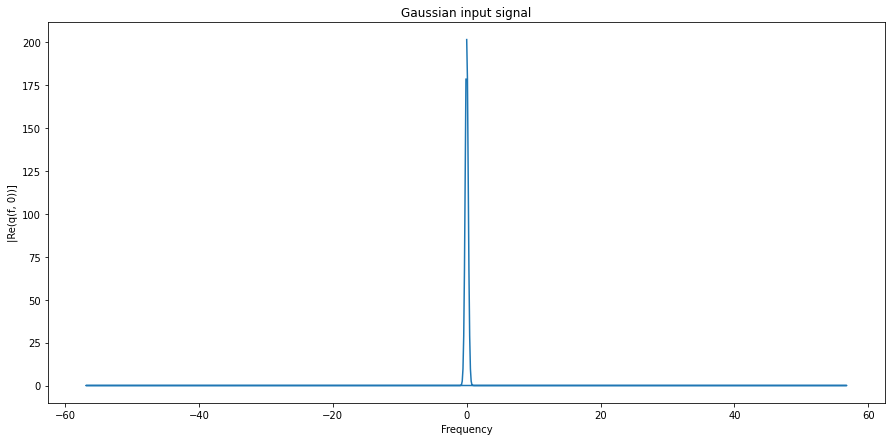

In [186]:
plt.plot(f, np.abs(q0f.real))
plt.xlabel('Frequency')
plt.ylabel('|Re(q(f, 0))]')
plt.title("Gaussian input signal")

In [187]:
# propagation (with zero noise), output in t,f
qzt, qzf = channel.channel(parameters.t, q0t, parameters.z, 0, 0) 
# equalized output
qzte, qzfe = equalizer.equalize(parameters.t, qzt, parameters.z)

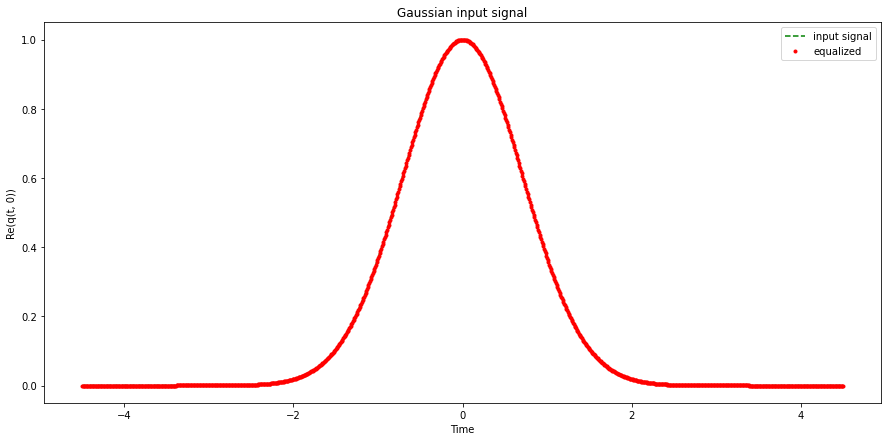

In [188]:
plt.plot(parameters.t, q0t.real, 'g--', label="input signal")
plt.plot(parameters.t, qzte.real, 'r.', label="equalized")

plt.xlabel('Time')
plt.ylabel('Re(q(t, 0))')
plt.title("Gaussian input signal")
plt.legend()

**Comments**

We can see that the equalization is very good, we are able to get back to the original signal. Let's verify this with the comparison function below.

### Comparison of Original and Equalized signals

In [189]:
def compare(x, y):
    """ This function compares the equalized signal with the input one """

    delta = np.absolute(x - y)
    return np.max(delta) <= 1e-6

In [190]:
# we compare the original signal and the equalized one
compare(q0t, qzte) 

True

## Demodulation, Detection and Demapping

### Question 17. Checking the first the **end-to-end implementation when noise is zero**. In this case, we should obtain $ \widehat{s} \approx  s $ with high accuracy

In [191]:
# bandwidth
bandwidth = 1
# Number of symbols
nsymbols = 16
# Size of the constellation
M = 16
# Sample size
Nt = 2**10
# Number of Layers of the Generative network
nLayers = 500
# Number of bits
nb = int(nsymbols * np.log2(M))
# Time mesh
timeMesh = int( (nb/bandwidth)+ (10*2/ nb) )

In [192]:
timeMesh

64

In [193]:
print("Number of bits : ", nb)

Number of bits :  64


In [194]:
# Initialize parameters
parameters = Parameters(bandwidth, nsymbols, M, Nt, nLayers, timeMesh)
# Initialize the Transmitor
transmitor = Transmitor()
# Initialize the Modulator
modulator = Modulator()
# Initialize the Channel
channel = Channel()
# Initialize the Equalizer
equalizer = Equalizer()
# Initialize the NNetGenerator
nnetGen = NNetGenerator(parameters)
# Initialize the Detector
detector = Detector(transmitor)
# Initialize the Demodulator
demodulator = Demodulator()

In [195]:
#source
b = transmitor.source(parameters.nb , parameters.p)

# symbol sequence
s = transmitor.bit_to_symb(b, parameters.M)

# Modulation
q0t = modulator.mod(parameters.t, s, parameters.B)
print("q0t : ", q0t.shape)

# propagation (with zero noise), output in t,f
qzt, qzf = channel.channel(parameters.t, q0t, 100, 0, parameters.B) 
# equalized output
qzte, qzfe = equalizer.equalize(parameters.t, qzt, 100)

print("qzt : ", qzt.shape)
print("qzte : ", qzte.shape)

print("comp : ", compare(q0t, qzte))

# Demodulation
#qzte = qzte.reshape(1,-1) # if Gaussian
shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

# Detection
stilde, indexes = detector.detector(shat, parameters.M)
bhat = detector.symbols_to_bit(indexes, parameters.M)

q0t :  (1, 1024)
qzt :  (1, 1024)
qzte :  (1, 1024)
comp :  True


#### Let's compare the symbol-error-rate and the bit-error-rate

In [196]:
b

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

In [197]:
bhat

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

In [198]:
ser = detector.ser(s, stilde)  # symbol error rate
ber = detector.ber(b, bhat)  # bit error rate

In [199]:
print("The bit-error-rate is : ",ber)
print("The symbol-error-rate is : ",ser)

The bit-error-rate is :  0.0
The symbol-error-rate is :  0.0


## Inter-symbol interference

For $t_{0} = 4$

In [200]:
A1 = 1
A2 = 2
D = 1
t0 = 4

### z = 0

In [201]:
z = 0
qt0 = A1*np.exp(-(parameters.t+t0)**2/(2*D**2)) + A2*np.exp(-(parameters.t-t0)**2/(2*D**2))
qt1, qf1 = channel.channel(parameters.t, qt0, z, 0, parameters.B)

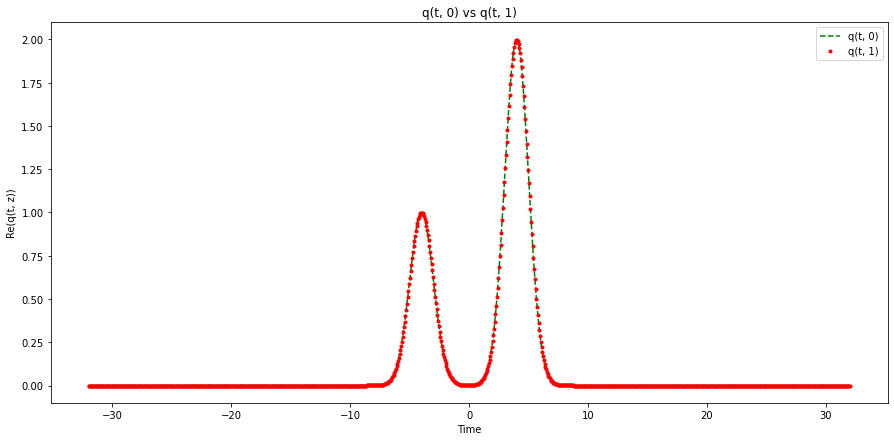

In [202]:
plt.plot(parameters.t, np.squeeze(qt0.real), 'g--', label='q(t, 0)')
plt.plot(parameters.t, np.squeeze(qt1.real), 'r.', label='q(t, 1)')
plt.xlabel('Time')
plt.ylabel('Re(q(t, z))')
plt.legend()
plt.title('q(t, 0) vs q(t, 1)')
plt.show()

### z = 1

In [203]:
z = 1
qt0 = A1*np.exp(-(parameters.t+t0)**2/(2*D**2)) + A2*np.exp(-(parameters.t-t0)**2/(2*D**2))
qt1, qf1 = channel.channel(parameters.t, qt0, z, 0, parameters.B)

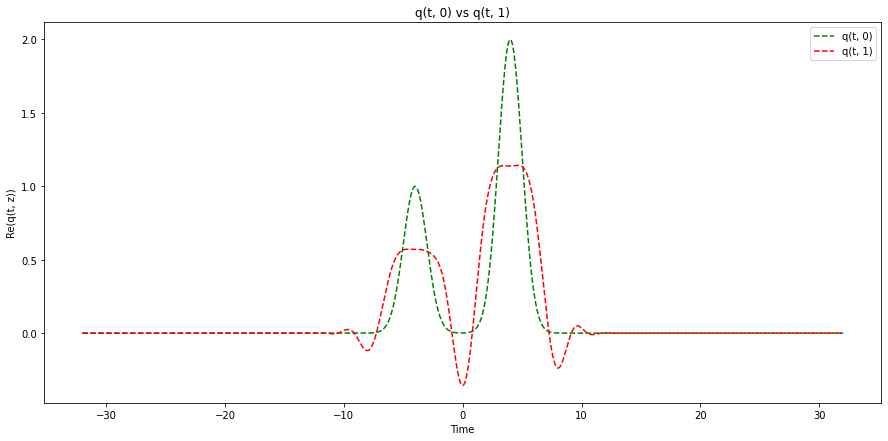

In [204]:
plt.plot(parameters.t, np.squeeze(qt0.real), 'g--', label='q(t, 0)')
plt.plot(parameters.t, np.squeeze(qt1.real), 'r--', label='q(t, 1)')
plt.xlabel('Time')
plt.ylabel('Re(q(t, z))')
plt.legend()
plt.title('q(t, 0) vs q(t, 1)')
plt.show()

For $t_{0} = 7$

In [205]:
t0 = 7

### z = 0

In [206]:
z= 0
qt0 = A1*np.exp(-(parameters.t+t0)**2/(2*D**2)) + A2*np.exp(-(parameters.t-t0)**2/(2*D**2))
qt1, qf1 = channel.channel(parameters.t, qt0, z, 0, parameters.B)

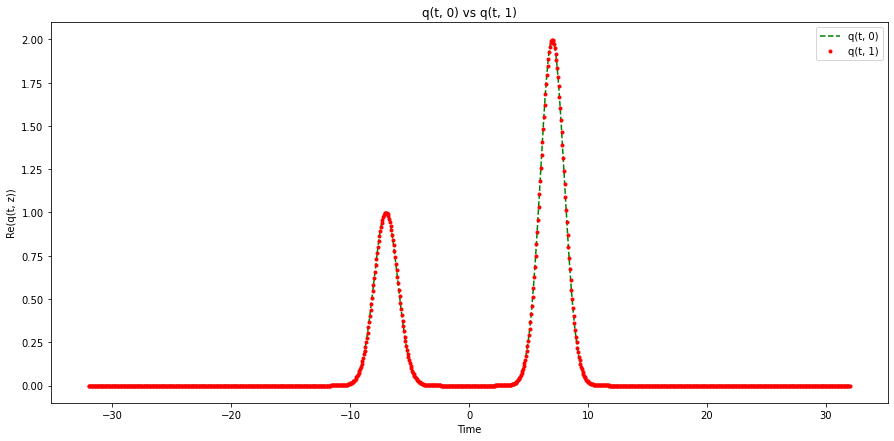

In [207]:
plt.plot(parameters.t, np.squeeze(qt0.real), 'g--', label='q(t, 0)')
plt.plot(parameters.t, np.squeeze(qt1.real), 'r.', label='q(t, 1)')
plt.xlabel('Time')
plt.ylabel('Re(q(t, z))')
plt.legend()
plt.title('q(t, 0) vs q(t, 1)')
plt.show()

### z = 1

In [208]:
z= 1
qt0 = A1*np.exp(-(parameters.t+t0)**2/(2*D**2)) + A2*np.exp(-(parameters.t-t0)**2/(2*D**2))
qt1, qf1 = channel.channel(parameters.t, qt0, z, 0, parameters.B)

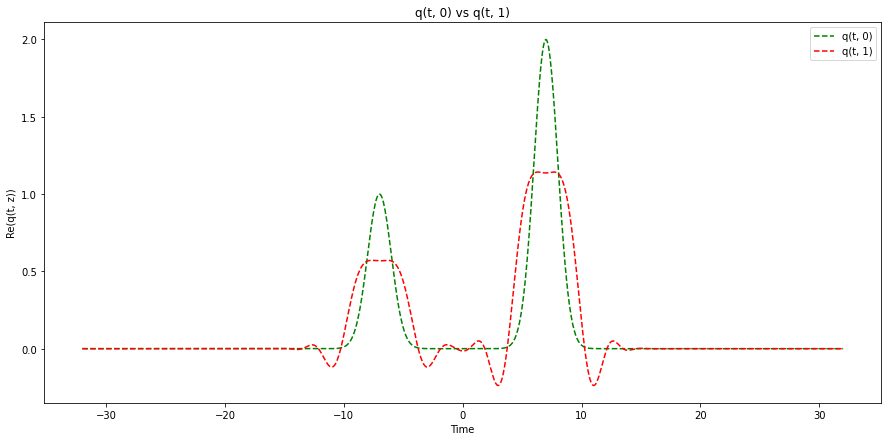

In [209]:
plt.plot(parameters.t, np.squeeze(qt0.real), 'g--', label='q(t, 0)')
plt.plot(parameters.t, np.squeeze(qt1.real), 'r--', label='q(t, 1)')
plt.xlabel('Time')
plt.ylabel('Re(q(t, z))')
plt.legend()
plt.title('q(t, 0) vs q(t, 1)')
plt.show()

## Equilization

* Let's see if the ISI is completely canceled with equalization.

In [210]:
qt1e, qf1e = equalizer.equalize(parameters.t, qt1, parameters.z)

**In time domain**

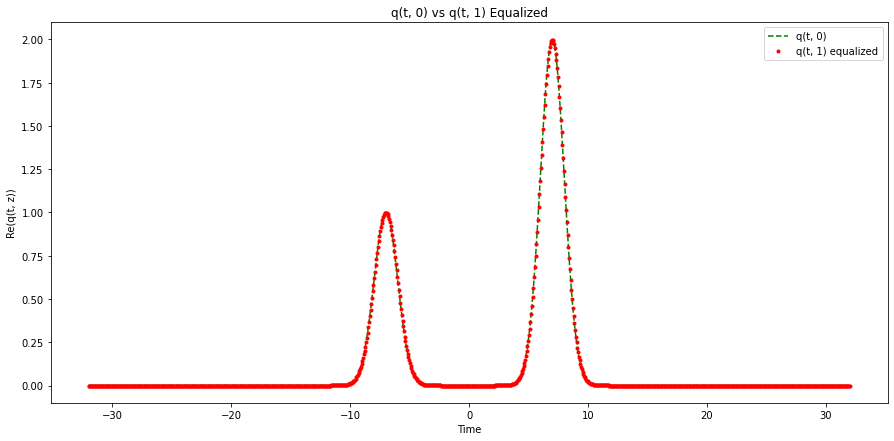

In [211]:
plt.plot(parameters.t, np.squeeze(qt0.real), 'g--', label='q(t, 0)')
plt.plot(parameters.t, np.squeeze(qt1e.real), 'r.', label='q(t, 1) equalized')
plt.xlabel('Time')
plt.ylabel('Re(q(t, z))')
plt.legend()
plt.title('q(t, 0) vs q(t, 1) Equalized')
plt.show()

**In frequency domain**

In [213]:
qf0 = np.fft.fft(qt0)

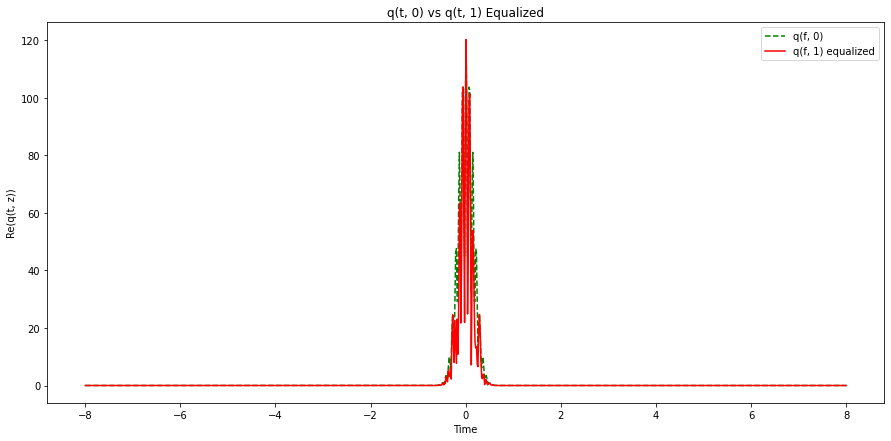

In [221]:
plt.plot(parameters.f, np.absolute(np.squeeze(np.fft.fftshift(qf0))), 'g--', label='q(f, 0)')
plt.plot(parameters.f, np.absolute(np.squeeze(np.fft.fftshift(qf1.real))), 'r-', label='q(f, 1) equalized')
plt.xlabel('Time')
plt.ylabel('Re(q(t, z))')
plt.legend()
plt.title('q(t, 0) vs q(t, 1) Equalized')
plt.show()

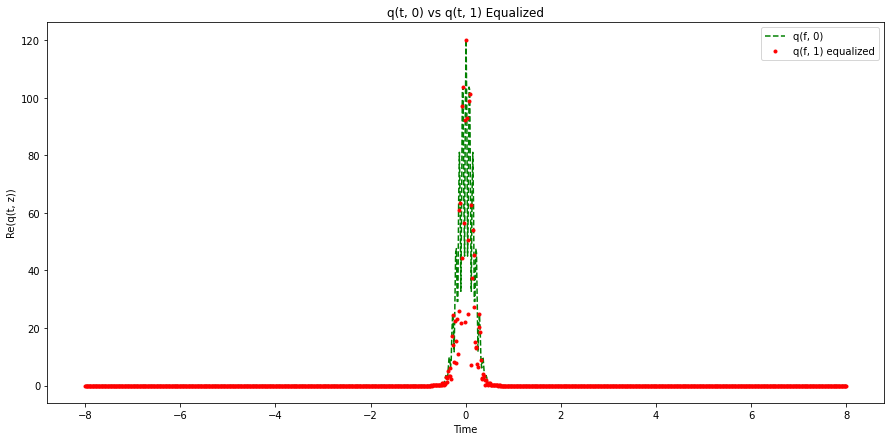

In [222]:
plt.plot(parameters.f, np.absolute(np.squeeze(np.fft.fftshift(qf0))), 'g--', label='q(f, 0)')
plt.plot(parameters.f, np.absolute(np.squeeze(np.fft.fftshift(qf1.real))), 'r.', label='q(f, 1) equalized')
plt.xlabel('Time')
plt.ylabel('Re(q(t, z))')
plt.legend()
plt.title('q(t, 0) vs q(t, 1) Equalized')
plt.show()

## 2.2.4 Performance evaluation

### Noisy channel

We now turn to the noisy channel, let's see how the BER evoluate.

In [261]:
def test_performance_noisy_channel(sigma2, z, t0, parameters):
    qt0 = A1*np.exp(-(parameters.t+t0)**2/(2*D**2)) + A2*np.exp(-(parameters.t-t0)**2/(2*D**2))
    qt1, qf1 = channel.channel(parameters.t, qt0, z, sigma2, parameters.B)
    plt.plot(parameters.t, np.squeeze(qt0.real), 'g--', label='q(t, 0)')
    plt.plot(parameters.t, np.squeeze(qt1.real), 'r--', label='q(t, 1)')
    plt.xlabel('Time')
    plt.ylabel('Re(q(t, z))')
    plt.legend()
    plt.title('q(t, 0) vs q(t, 1)')
    plt.show()

    # equalized output
    qzte, qzfe = equalizer.equalize(parameters.t, qt1, z)

    print("compare(q0t, qzte) : ", compare(q0t, qzte))

    # Demodulation
    qzte = qzte.reshape(1,-1) # if Gaussian
    shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

    # Detection
    stilde, indexes = detector.detector(shat, parameters.M)
    bhat = detector.symbols_to_bit(indexes, parameters.M)
    
    ser = detector.ser(s, stilde)  # symbol error rate
    ber = detector.ber(b, bhat)  # bit error rate
    
    print("The bit-error-rate is : ",ber)
    print("The symbol-error-rate is : ",ser)
    return bhat, stilde

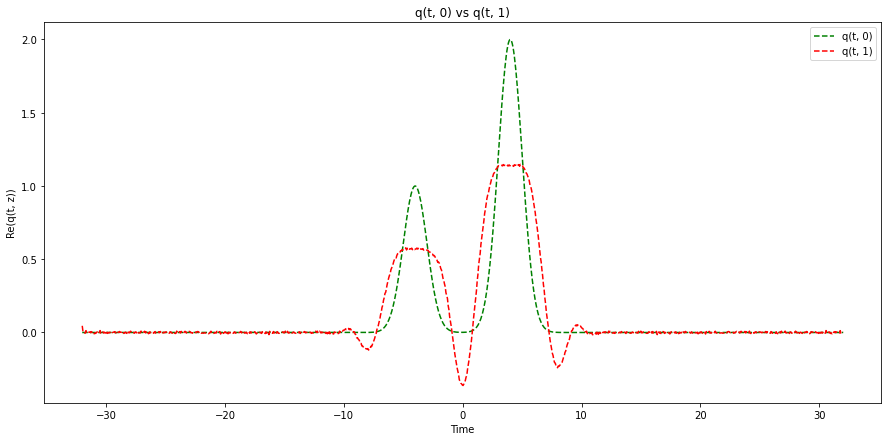

compare(q0t, qzte) :  False
The bit-error-rate is :  0.546875
The symbol-error-rate is :  2.7885747066176165


In [262]:
sigma2 = 0.05
z = 1
t0 = 4
bhat, stilde = test_performance_noisy_channel(sigma2, z, t0, parameters)

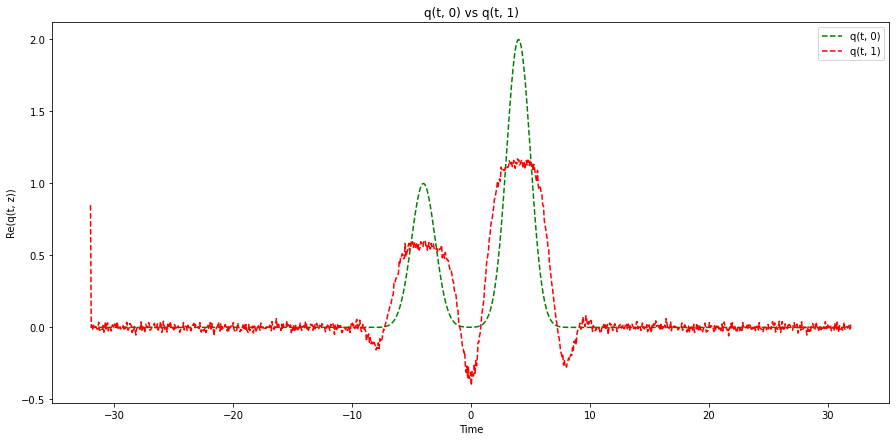

compare(q0t, qzte) :  False
The bit-error-rate is :  0.453125
The symbol-error-rate is :  2.2146970504922754


In [263]:
sigma2 = 0.85
z = 1
t0 = 4
bhat, stilde = test_performance_noisy_channel(sigma2, z, t0, parameters)

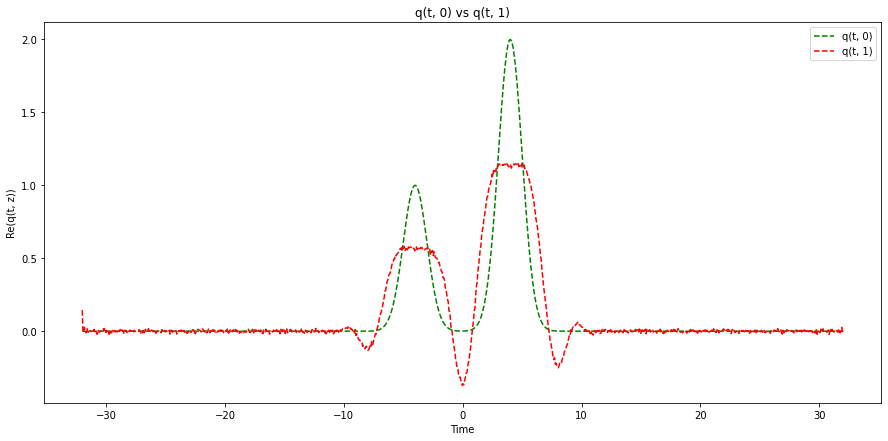

compare(q0t, qzte) :  False
The bit-error-rate is :  0.484375
The symbol-error-rate is :  2.3757277519011173


In [264]:
sigma2 = 0.15
z = 1
t0 = 4
bhat, stilde = test_performance_noisy_channel(sigma2, z, t0, parameters)

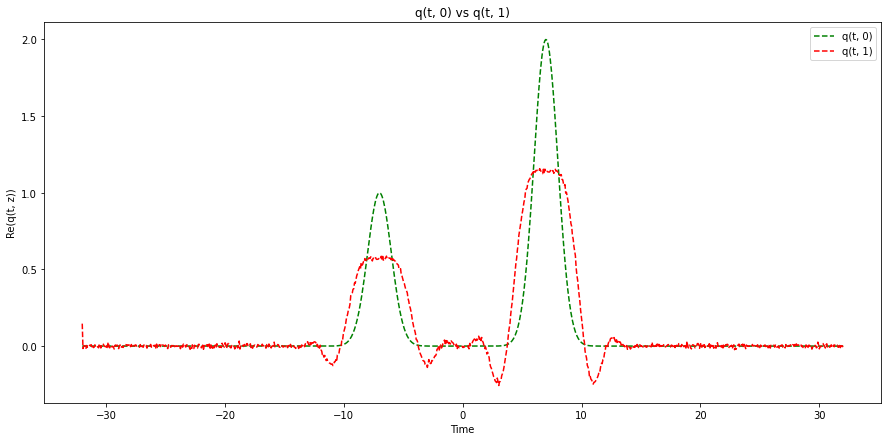

compare(q0t, qzte) :  False
The bit-error-rate is :  0.46875
The symbol-error-rate is :  2.4030215585058743


In [265]:
sigma2 = 0.15
z = 1
t0 = 7
bhat, stilde = test_performance_noisy_channel(sigma2, z, t0, parameters)

## BER vs SNR

We will plot the BER as a function of SNR, for an M-QAM constellation with M = 2, 4, 8, 16 in the same figure.

In [254]:
def compute_signal_power(s, M):
    s = np.squeeze(s)
    p = 0
    for i in range(len(s)):
        p = p + np.absolute(s[i])**2
    return p/M

def ber_vs_snr(M):
    

### In a noisy channel

We should see a degradatation of the power.

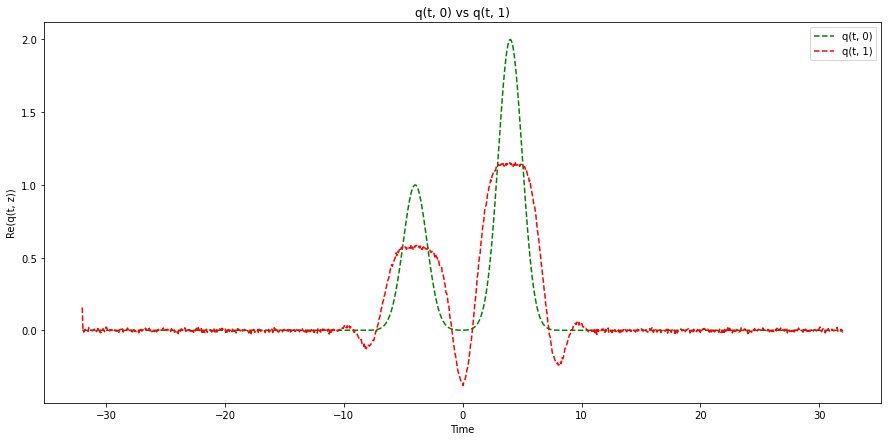

compare(q0t, qzte) :  False
The bit-error-rate is :  0.484375
The symbol-error-rate is :  2.36179801132098


In [283]:
sigma2 = 0.15
z = 1
t0 = 4
bhat, stilde = test_performance_noisy_channel(sigma2, z, t0, parameters)

In [284]:
s

array([-1.+1.j, -2.-1.j, -1.+1.j, -2.-2.j,  2.-2.j,  1.+1.j,  1.-1.j,
       -2.+1.j,  1.+1.j, -2.+1.j, -1.-1.j, -1.+1.j, -1.-2.j,  2.-2.j,
       -2.+1.j,  2.-2.j])

In [285]:
stilde

array([-1.+1.j,  1.+1.j,  1.+1.j,  1.-1.j,  1.-1.j,  1.-1.j,  1.-1.j,
        1.+1.j, -1.+1.j,  1.-1.j,  1.+1.j,  1.-1.j,  2.-1.j,  1.+1.j,
        1.-1.j,  1.-1.j])

In [286]:
compute_signal_power(s, M)

4.437500000000001

In [287]:
compute_signal_power(stilde, M)

2.1875000000000004

# 2.3 Generative deep neural network

In [6]:
q0t = modulator.mod(parameters.t,val_s, parameters.B)
y_gen = nnetGen.nnet_gen(q0t)

# Data Gen

In [9]:
# Generating the dataset
def generateDataset(nbrOfObservations, parameters, transmitor, modulator, nnetGen, demodulator, detector, isGaussian =False):

    X = np.ndarray((nbrOfObservations, parameters.N), dtype=np.complex128)
    y = np.ndarray((nbrOfObservations, parameters.N), dtype=np.complex128)    
    bits_in = np.ndarray((nbrOfObservations, parameters.nb))
    bhat_out = np.ndarray((nbrOfObservations, parameters.nb))
    symb_in = np.ndarray((nbrOfObservations, parameters.n))
    symb_out = np.ndarray((nbrOfObservations, parameters.n))


    print("[INFO] Generating the dataset...")

    for i in tqdm(range(nbrOfObservations)):
        
        # Constellation
        constellation = transmitor.build_constellations(parameters.M)
        
        #source
        source = transmitor.source(parameters.nb , parameters.p) # USE IT FOR NEXT PART OF BITS
        
        # Bits to Symboles - symbol sequence
        bitsToSymbols = transmitor.bit_to_symb(source, parameters.M)

        # symbol sequence, we create a list of values of the complex symbols to use them in modulation
        s = transmitor.bit_to_symb(source, parameters.M)
        
        # channel - we take gaussian input
        if isGaussian:
            q0t = parameters.A*np.exp(-parameters.t**2) 

        else :
            q0t = modulator.mod(parameters.t,s, parameters.B)  
        
        # Neural Net Generator
        y_gen = nnetGen.nnet_gen(q0t)
        # equalized y_gen
        qzte, qzfe = equalizer.equalize(parameters.t, y_gen, parameters.z) # equalized output
        qzte = qzte.reshape(1,-1)
        # demodulation
        shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

        # detection
        stilde, indexes = detector.detector(shat, parameters.M)
        bhat = detector.symbols_to_bit(indexes, parameters.M)
        
        # SOURCE IS THE SEQUENCE OF BITS TO BE LEARNED
        
        # Modulated signal
        X[i] = np.squeeze(q0t)
        # Neural Net Generator
        y[i] = y_gen
        # original bit sequence (source)
        bits_in[i] = source
        # estimated bit sequence
        bhat_out[i] = bhat
        # original symbol sequence (source)

        symb_in[i] = np.squeeze(s)
        # estimated symbol sequence
        symb_out[i] = np.squeeze(shat)
        
    print("[INFO] The dataset is ready now !")

    return X, y, bits_in, bhat_out, symb_in, symb_out

In [18]:
nbrOfObservations = 10000 #(1h for 10k observations)

In [11]:
X, y, bits_in, bhat_out, symb_in, symb_out = generateDataset(nbrOfObservations, parameters, transmitor, modulator, nnetGen, demodulator, detector, isGaussian =False)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

[INFO] Generating the dataset...


C:\Python36\lib\site-packages\ipykernel_launcher.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Python36\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:22<00:00,  2.42it/s]

[INFO] The dataset is ready now !


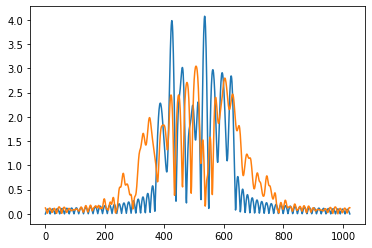

In [8]:
plt.plot(np.abs(q0t))
plt.plot(np.abs(y_gen))

C:\Python36\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Python36\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


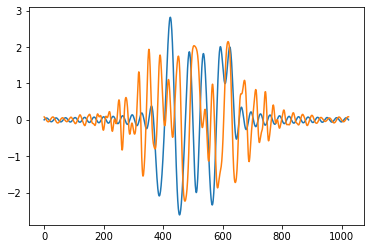

In [7]:
plt.plot(q0t)
plt.plot(y_gen)

# Data preparation

In [15]:
t1 = time.time()
# if scaling=True, we are using min-max scaler
df = prepareDataFrame(X, y, scaling=False)
#df.to_csv("../data/data_90K.csv.gz", index=False, compression="gzip")
t2 = time.time()
print("Toral time to prepare the dataframe is : ", t2-t1, " seconds.")

 22%|██████████████████                                                              | 45/200 [00:00<00:00, 436.90it/s]


 [INFO] {fromComplexToReal} runing...


 52%|████████████████████████████████████████▌                                     | 104/200 [00:00<00:00, 1033.22it/s]

 [INFO] {fromComplexToReal} vect_real.shape :  (200, 2048)

 [INFO] {fromComplexToReal} runing...


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 958.67it/s]

 [INFO] {fromComplexToReal} vect_real.shape :  (200, 2048)
{prepareDataFrame} df_.shape :  (200, 4096)
Toral time to prepare the dataframe is :  0.525623083114624  seconds.


In [16]:
n_samples, n_features = X.shape
n_hidden = 512

In [17]:
withReshape = True
ts = 0.25
X_train, X_test, y_train, y_test = prepareTrainAndTestData(df, withReshape, ts)

[INFO] - {prepareTrainAndTestData} converting from pandas to numpy...
[INFO] train and test data are ready.
X.shape :  (200, 2048)
y.shape :  (200, 2048)
X_train.shape :  (150, 2048, 1)
y_train.shape :  (150, 2048, 1)
X_test.shape :  (50, 2048, 1)
y_test.shape :  (50, 2048, 1)


In [18]:
X_train = np.squeeze(X_train)
X_test = np.squeeze(X_test)
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

# Model

In [20]:
optimizer = Adam()
opti = 'Adam'
n_features = 2048
n_output = 2048
rect_mlp = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [21]:
rect_mlp.add(Dense(2048, input_shape=(n_features,)))
rect_mlp.add(Activation('selu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(1024))
rect_mlp.add(Activation('selu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(512))
rect_mlp.add(Activation('selu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(1024))
rect_mlp.add(Activation('selu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(n_output))
rect_mlp.add(Activation('selu'))

print ()
rect_mlp.summary(name="MLP")


+-----+
| MLP |
+-----+
Input Shape: (2048,)
+--------------------+------------+--------------+
| Layer Type         | Parameters | Output Shape |
+--------------------+------------+--------------+
| Dense              | 4196352    | (2048,)      |
| Activation (SELU)  | 0          | (2048,)      |
| Dropout            | 0          | (2048,)      |
| BatchNormalization | 4096       | (2048,)      |
| Dense              | 2098176    | (1024,)      |
| Activation (SELU)  | 0          | (1024,)      |
| Dropout            | 0          | (1024,)      |
| BatchNormalization | 2048       | (1024,)      |
| Dense              | 524800     | (512,)       |
| Activation (SELU)  | 0          | (512,)       |
| Dropout            | 0          | (512,)       |
| BatchNormalization | 1024       | (512,)       |
| Dense              | 525312     | (1024,)      |
| Activation (SELU)  | 0          | (1024,)      |
| Dropout            | 0          | (1024,)      |
| BatchNormalization | 2048       | 

In [22]:
num_epochs = 10
batch_size = 256

In [23]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err_rect, val_err_rect = rect_mlp.fit(X_train, y_train, num_epochs, batch_size)

[INFO] Batch size :  256
[INFO] Training epochs number :  10


[INFO] Training loss on epoch  1  :  0.51806
[INFO] Validation loss on epoch  1  :  0.45594
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.45551
[INFO] Validation loss on epoch  2  :  0.48951
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.38984
[INFO] Validation loss on epoch  3  :  0.59075
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.33869
[INFO] Validation loss on epoch  4  :  0.83493
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.31109
[INFO] Validation loss on epoch  5  :  1.15077
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.29249
[INFO] Validation loss on epoch  6  :  1.49968
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.28000
[INFO] Validation loss on epoch  7  :  1.84788
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.26379
[INFO] Validation loss on epoch  8  :  2.17695
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.25188
[INFO] Validation loss on epoch  9  :  2.43993
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.24087
[INFO] Validation loss on epoch  10  :  2.64036
-------------------------------------------------------------------------------


In [50]:
index_pred= 0
y_pred = evaluate_model(rect_mlp, X_test, y_test, index_pred, opti, train_err_rect, val_err_rect)

NameError: name 'evaluate_model' is not defined

## Performance evaluation

In [ ]:
s = bitToSymb(b, M)
q0t = mod(t, s, B)

In [51]:
y_pred

array([[-0.63005374, -1.59363084,  0.90690384, ...,  0.79101574,
        -1.34517683, -0.25255688]])

In [53]:
# propagation & equalization.
q0t = fromRealToComplex(y_pred)
qzt, qzf = channel.channel(parameters.t, q0t, parameters.z, parameters.sigma2, parameters.B) # output in t,f
qzte, qzfe = equalizer.equalize(parameters.t, qzt, parameters.z) # equalized output
# demodulation
shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

# detection
stilde, indexes = detector.detector(shat, M)
bhat = detector.symbols_to_bit(indexes, M)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.90it/s]


 [INFO] {fromRealToComplex} runing...
[INFO] {fromRealToComplex} vect_im.shape :  (1, 1024)
[channel] qzt : [[ 1.26500192+0.0019399j  -2.73153458+0.56513628j  1.06782327+0.17706405j
  ... -0.95139833+0.32534958j -2.29527718+0.84773806j
  -1.61576552-0.73295409j]]
[channel] qzf : [[ 231.90072498+221.27979258j -238.26652423 -91.82142005j
    98.03501858 +16.84368961j ... -239.27998915-226.70653915j
   300.02135842+281.54136407j -244.79443277-323.01794894j]]
[Equalizer] qzte : [[-0.63005376-1.59363079j  0.90690386-0.28902468j -0.2432705 -1.02888262j
  ... -1.58655644+1.13197743j -0.69098031+0.79101574j
  -1.34517682-0.2525569j ]]
[Equalizer] qzfe : [[ 231.90072498+221.27979258j -239.14044461 -89.52070989j
    98.61138699 +13.05255161j ... -258.02121583-205.12391446j
   310.65003401+269.76825528j -247.8963536 -320.64358332j]]


In [57]:
qzt.shape

(1, 1024)

In [29]:
shat

array([[-2.60733549-3.31454681j],
       [ 0.83178736+2.73640648j],
       [ 0.95153583-1.43414499j],
       [-0.07969793+3.19582603j],
       [ 1.51985879-3.22977955j],
       [-2.19806618+4.89734426j],
       [ 2.94428658+0.23852739j],
       [ 2.05109064+1.80774651j],
       [ 0.46441487+8.45062161j],
       [-1.95283607-1.12799967j],
       [-1.27438   -1.86820945j],
       [ 1.50666975-1.17863641j],
       [16.39241219-1.53011492j],
       [-1.34442668-1.45247614j],
       [ 0.34290359-1.97204797j],
       [-1.53898609+6.42212326j]])

In [34]:
b = transmitor.source(parameters.nb , parameters.p)
s = transmitor.bit_to_symb(b, 16)

In [35]:
shat.shape

(16, 1)

In [36]:
ser = detector.ser(s, shat)  # symbol error rate
ber = detector.ber(b, bhat)  # bit error rate

In [37]:
ser

75.44596722617987

In [38]:
ber

0.484375